In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft_ELMo
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for harem_ELMo+CNN+Embeddings_fasttext_cbow_2_0
64
64


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo', '1', '0']
['harem-ft', 'ELMo+CNN', '0', '0']
['harem-ft', 'ELMo+CNN', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'glove', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'glove', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embedding

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,11,20,00:46:22,2782.0,139.10,0.998377,0.998466,0.981112,0.980583,0.980847,3.849414,0.980111,0.982188,0.823232,0.831633,0.827411,62.998245,0.978612,0.980188,0.829522,0.799332,0.814147,77.248705
1,harem-ft_ELMo_1_0,harem-ft,ELMo,No,No,1,0,12,20,00:22:47,1367.0,68.35,0.997897,0.998055,0.978373,0.973635,0.975998,3.954796,0.989643,0.990540,0.879177,0.892950,0.886010,35.350330,0.978402,0.980203,0.823936,0.795326,0.809378,83.973366
2,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,16,20,00:29:28,1768.0,88.40,0.998086,0.998276,0.977568,0.975458,0.976512,3.587718,0.980767,0.983281,0.831266,0.854592,0.842767,82.332504,0.978867,0.980443,0.820000,0.807679,0.813793,93.089778
3,harem-ft_ELMo+CNN_1_0,harem-ft,ELMo+CNN,No,No,1,0,17,20,00:25:10,1510.0,75.50,0.997874,0.998078,0.977640,0.976325,0.976982,4.509836,0.988150,0.989146,0.882199,0.879896,0.881046,41.372279,0.978702,0.980398,0.827420,0.802003,0.814513,92.398115
4,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,0,0,11,20,00:25:16,1516.0,75.80,0.997089,0.997336,0.968091,0.965480,0.966784,5.961578,0.980658,0.982953,0.822055,0.836735,0.829330,62.950836,0.977771,0.979572,0.819931,0.796661,0.808129,70.118833
5,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_1_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,1,0,10,20,00:47:02,2822.0,141.10,0.996483,0.996811,0.964025,0.958838,0.961424,6.172601,0.989743,0.990739,0.886010,0.892950,0.889467,28.274580,0.978191,0.980023,0.824880,0.803673,0.814138,66.954131
6,harem-ft_ELMo+CNN+Embeddings_fasttext_skip_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,skip,0,0,18,20,00:24:52,1492.0,74.60,0.998690,0.998836,0.985672,0.983279,0.984474,2.842341,0.979128,0.980876,0.816626,0.852041,0.833958,94.846123,0.978912,0.980428,0.826356,0.804007,0.815028,102.920017
7,harem-ft_ELMo+CNN+Embeddings_fasttext_skip_1_0,harem-ft,ELMo+CNN+Embeddings,fasttext,skip,1,0,15,20,00:47:07,2827.0,141.35,0.998745,0.998937,0.986545,0.986279,0.986412,2.730447,0.988946,0.990042,0.889744,0.906005,0.897801,44.425736,0.977801,0.979362,0.809366,0.813689,0.811522,94.092474
8,harem-ft_ELMo+CNN+Embeddings_glove_0_0,harem-ft,ELMo+CNN+Embeddings,glove,No,0,0,19,20,00:24:32,1472.0,73.60,0.998601,0.998757,0.983275,0.983010,0.983142,3.082004,0.981204,0.983062,0.814010,0.859694,0.836228,90.117733,0.977891,0.979482,0.811536,0.808013,0.809771,108.923202
9,harem-ft_ELMo+CNN+Embeddings_glove_1_0,harem-ft,ELMo+CNN+Embeddings,glove,No,1,0,9,20,00:32:08,1928.0,96.40,0.998485,0.998643,0.984071,0.980630,0.982347,2.985664,0.987254,0.988249,0.868020,0.892950,0.880309,38.114150,0.978266,0.979812,0.813745,0.818364,0.816048,73.056805


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:27:33.031250'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,32.0,81.406551,0.351357,80.767272,0.811337,0.814219,0.816073,82.029527
Não,32.0,81.041241,0.625699,79.414298,0.807394,0.811056,0.813843,82.436070


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+Vetor,28.0,81.270829,0.576050,79.836929,0.808757,0.813565,0.816188,82.436070
ELMo+CNN+Vetor,28.0,81.232608,0.443037,80.208860,0.809360,0.811787,0.815158,82.229846
ELMo,4.0,81.204261,0.374584,80.842322,0.809139,0.811763,0.814666,81.622177
ELMo+CNN,4.0,80.854018,0.967139,79.414298,0.807319,0.812752,0.813973,81.451339


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,24.0,81.390120,0.483131,80.479863,0.811333,0.813508,0.816657,82.436070
Sem Vetor,16.0,81.173733,0.614407,79.414298,0.809673,0.813764,0.815764,81.825810
CBoW,24.0,81.091115,0.508244,79.836929,0.807602,0.810494,0.814223,82.029527


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Wang2Vec,16.0,81.514487,0.522225,80.722485,0.811897,0.815098,0.818998,82.436070
GloVe,8.0,81.318327,0.514860,80.208860,0.812574,0.814702,0.816133,81.825810
Word2Vec,16.0,81.183958,0.552213,79.836929,0.809614,0.812679,0.815697,82.020202
Sem Vetor,8.0,81.029139,0.704309,79.414298,0.809139,0.812752,0.814239,81.622177
FastText,16.0,81.023406,0.337774,80.182156,0.808410,0.810665,0.812196,81.502792


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           2.0  81.955053   
Sim         ELMo+Vetor     Word2Vec  Skip-Gram           2.0  81.825740   
            ELMo+CNN+Vetor Wang2Vec  CBoW                2.0  81.737367   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           2.0  81.717579   
Sim         ELMo+Vetor     Wang2Vec  CBoW                2.0  81.716755   
                           GloVe     Sem Vetor           2.0  81.696354   
                           Wang2Vec  Skip-Gram           2.0  81.632462   
Não         ELMo+Vetor     GloVe     Sem Vetor           2.0  81.494801   
Sim         ELMo+CNN+Vetor Word2Vec  Skip-Gram           2.0  81.491893   
Não         ELMo+CNN+Vetor Word2Vec  Skip-Gram           2.0  81.438593   
Sim         ELMo+CNN       Sem Vetor Sem Vetor           2.0  81.415325   
            ELMo+CNN+Vetor FastText  Skip-Gram           2.0  81.327487   
            ELMo+Vetor     Word2Vec  CBoW                2.0  81.324422   
            ELMo+CNN+Vetor GloVe     Sem Vetor           2.0  81.290937   
Não         ELMo+CNN+Vetor FastText  Skip-Gram           2.0  81.284046   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           2.0  81.268174   
                           Word2Vec  CBoW                2.0  81.245924   
Não         ELMo           Sem Vetor Sem Vetor           2.0  81.232249   
Sim         ELMo           Sem Vetor Sem Vetor           2.0  81.176272   
Não         ELMo+Vetor     Wang2Vec  CBoW                2.0  81.155736   
Sim         ELMo+Vetor     FastText  Skip-Gram           2.0  81.123042   
                                     CBoW                2.0  81.119309   
            ELMo+CNN+Vetor FastText  CBoW                2.0  81.113352   
Não         ELMo+CNN+Vetor Wang2Vec  CBoW                2.0  80.932769   
                           FastText  CBoW                2.0  80.898408   
            ELMo+Vetor     Word2Vec  Skip-Gram           2.0  80.826770   
            ELMo+CNN+Vetor GloVe     Sem Vetor           2.0  80.791214   
            ELMo+Vetor     FastText  Skip-Gram           2.0  80.790596   
            ELMo+CNN+Vetor Word2Vec  CBoW                2.0  80.718765   
            ELMo+Vetor     Word2Vec  CBoW                2.0  80.599558   
                           FastText  CBoW                2.0  80.531010   
            ELMo+CNN       Sem Vetor Sem Vetor           2.0  80.292712   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           0.680260  81.474037   
Sim         ELMo+Vetor     Word2Vec  Skip-Gram           0.275011  81.631277   
            ELMo+CNN+Vetor Wang2Vec  CBoW                0.191972  81.601622   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.724455  81.205312   
Sim         ELMo+Vetor     Wang2Vec  CBoW                0.442326  81.403982   
                           GloVe     Sem Vetor           0.183078  81.566898   
                           Wang2Vec  Skip-Gram           0.491303  81.285059   
Não         ELMo+Vetor     GloVe     Sem Vetor           0.203639  81.350806   
Sim         ELMo+CNN+Vetor Word2Vec  Skip-Gram           0.088853  81.429065   
Não         ELMo+CNN+Vetor Word2Vec  Skip-Gram           0.523802  81.068209   
Sim         ELMo+CNN       Sem Vetor Sem Vetor           0.050932  81.379310   
            ELMo+CNN+Vetor FastText  Skip-Gram           0.247920  81.152181   
            ELMo+Vetor     Word2Vec  CBoW                0.410450  81.034189   
            ELMo+CNN+Vetor GloVe     Sem Vetor           0.443862  80.977079   
Não         ELMo+CNN+Vetor FastText  Skip-Gram           0.187355  81.151566   
Sim         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.708382  80.767272   
                           Word2Vec  CBoW                0.28

In [18]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,8.0,0.816433,0.005629,0.807673,0.812651,0.816216,0.820424,0.824361
word2vec,skip,8.0,0.813957,0.004837,0.804799,0.811473,0.814919,0.816757,0.820202
wang2vec,cbow,8.0,0.813857,0.004792,0.807225,0.810488,0.814747,0.816695,0.820295
glove,No,8.0,0.813183,0.005149,0.802089,0.812574,0.814702,0.816133,0.818258
fasttext,skip,8.0,0.811313,0.002574,0.807308,0.810213,0.811519,0.812299,0.815028
No,No,8.0,0.810291,0.007043,0.794143,0.809139,0.812752,0.814239,0.816222
word2vec,cbow,8.0,0.809722,0.005630,0.798369,0.807309,0.810392,0.813836,0.816147
fasttext,cbow,8.0,0.809155,0.003894,0.801822,0.807952,0.808716,0.811348,0.814138


In [19]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,8.0,0.816433,0.005629,0.807673,0.812651,0.816216,0.820424,0.824361
word2vec,8.0,0.813957,0.004837,0.804799,0.811473,0.814919,0.816757,0.820202
glove,8.0,0.813183,0.005149,0.802089,0.812574,0.814702,0.816133,0.818258
fasttext,8.0,0.811313,0.002574,0.807308,0.810213,0.811519,0.812299,0.815028
No,8.0,0.810291,0.007043,0.794143,0.809139,0.812752,0.814239,0.816222


In [20]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,8.0,0.813857,0.004792,0.807225,0.810488,0.814747,0.816695,0.820295
glove,8.0,0.813183,0.005149,0.802089,0.812574,0.814702,0.816133,0.818258
No,8.0,0.810291,0.007043,0.794143,0.809139,0.812752,0.814239,0.816222
word2vec,8.0,0.809722,0.005630,0.798369,0.807309,0.810392,0.813836,0.816147
fasttext,8.0,0.809155,0.003894,0.801822,0.807952,0.808716,0.811348,0.814138


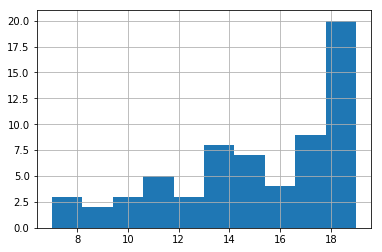

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count      64.000000
mean     1653.031250
std       416.410472
min      1333.000000
25%      1427.000000
50%      1487.000000
75%      1651.000000
max      2908.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
1,32.0,0.812821,0.004578,0.802089,0.809233,0.813831,0.816024,0.822298
0,32.0,0.811657,0.006060,0.794143,0.808350,0.812452,0.814475,0.824361


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,64.0,0.812239,0.00536,0.00067,0.8109,0.813578


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,8,0.810291,0.007043,0.002490,0.805411,0.815172
fasttext,16,0.810234,0.003378,0.000844,0.808579,0.811889
glove,8,0.813183,0.005149,0.001820,0.809615,0.816751
wang2vec,16,0.815145,0.005222,0.001306,0.812586,0.817704
word2vec,16,0.811840,0.005522,0.001381,0.809134,0.814545


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 4, 59) =  2.249, p =  0.07452575091841011357
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.249
Date:                Wed, 29 May 2019   Prob (F-statistic):             0.0745
Time:                        18:24:05   Log-Likelihood:                 248.88
No. Observations:                  64   AIC:                            -487.8
Df Residuals:                      59   BIC:                            -477.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------